<a href="https://colab.research.google.com/github/Rifaazs27/MLOps-Course-M2/blob/main/Sentiment_Analysis_with_Blanks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sentiment Analaysis NLP Workshop


## Environment Setup

In this workshop, we will work on a sentiment analysis task. Before we get started, you need to install transformers. Let us get it out of the way before we dive in.

In [13]:
!pip install pandas numpy scikit-learn joblib flask matplotlib seaborn fastapi==0.99.1 pydantic transformers uvicorn torch ipykernel datasets ipywidgets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 65.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 86.9 MB/s eta 0:00:00
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.11.7
    Uninstalling pydantic-2.11.7:
      Successfully uninstalled pydantic-2.11.7
  Attempting uninstall: starlette
    Found existing installation: starlette 0.47.3
    Uninstalling starlette-0.47.3:
      Successfully uninstalled starlette-0.47.3
  Attempting uninstall: fastapi
    Found existing installation: fastapi 0.116.1
    Uninstalling fastapi-0.116.1:
      Successfully uninstalled fastapi-0.116.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behav

In [14]:
# First, we need to setup our environment by changing runtime to gpu
import torch
torch.cuda.is_available()

True

In [15]:
!pip install -q transformers
!pip install datasets transformers huggingface_hub
!apt-get install git-lfs

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


Next, we have to get a personal access token from huggingface:

In [16]:
from huggingface_hub import notebook_login
notebook_login()

## Demo

In [17]:
# A little demo about what we will be doing
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis")
data = ["I love you", "I hate you"]
sentiment_pipeline(data)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cuda:0


[{'label': 'POSITIVE', 'score': 0.9998656511306763},
 {'label': 'NEGATIVE', 'score': 0.9991129040718079}]

## Getting the Data

In this tutorial, you'll use the IMDB dataset to fine-tune a DistilBERT model for sentiment analysis.

The IMDB dataset contains 25,000 movie reviews labeled by sentiment for training a model and 25,000 movie reviews for testing it. You'll use the IMDB dataset to fine-tune a BERT model that is able to classify whether a movie review is positive or negative. Once you train the model, you will use it to analyze new data! ⚡️

In [18]:
from datasets import load_dataset
imdb = load_dataset("imdb")

## Splitting the Data

In [19]:
# Create a smaller training dataset for faster training times
small_train_dataset = imdb["train"].shuffle(seed=42).select([i for i in list(range(3000))])
small_test_dataset = imdb["test"].shuffle(seed=42).select([i for i in list(range(300))])
print(small_train_dataset[0])
print(small_test_dataset[0])

{'text': 'There is no relation at all between Fortier and Profiler but the fact that both are police series about violent crimes. Profiler looks crispy, Fortier looks classic. Profiler plots are quite simple. Fortier\'s plot are far more complicated... Fortier looks more like Prime Suspect, if we have to spot similarities... The main character is weak and weirdo, but have "clairvoyance". People like to compare, to judge, to evaluate. How about just enjoying? Funny thing too, people writing Fortier looks American but, on the other hand, arguing they prefer American series (!!!). Maybe it\'s the language, or the spirit, but I think this series is more English than American. By the way, the actors are really good and funny. The acting is not superficial at all...', 'label': 1}
{'text': "<br /><br />When I unsuspectedly rented A Thousand Acres, I thought I was in for an entertaining King Lear story and of course Michelle Pfeiffer was in it, so what could go wrong?<br /><br />Very quickly, 

## Pre-processing

In [20]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [8]:
# Prepare the text inputs for the model
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_train = small_train_dataset.map(preprocess_function, batched= True)
tokenized_test = small_test_dataset.map(preprocess_function, batched= True)

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

In [9]:
# Use data_collector to convert our samples to PyTorch tensors and concatenate them with the correct amount of padding
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [21]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Defining Accuracy Metrics

For this task, we wil be using two accuracy metrics: Accuracy and F1 score:

* Accuracy is the proportion of correct predictions among the total number of
cases processed. It can be computed with: Accuracy = (TP + TN) / (TP + TN + FP + FN) Where: TP: True positive TN: True negative FP: False positive FN: False negative
* The F1 score is the harmonic mean of the precision and recall. It can be computed with the equation: F1 = 2 * (precision * recall) / (precision + recall)

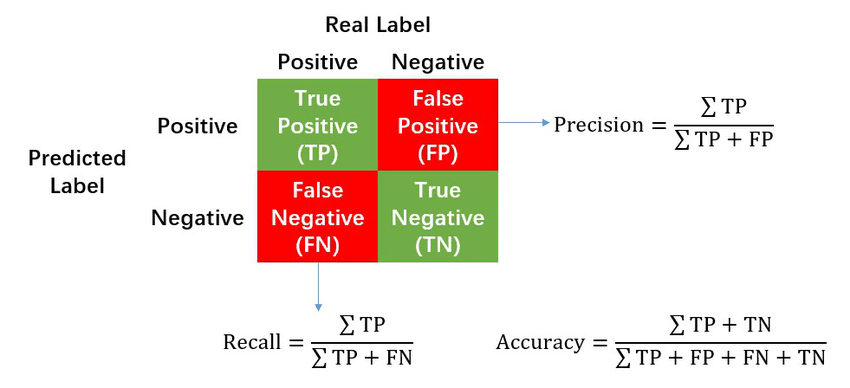![image.png](
  
)

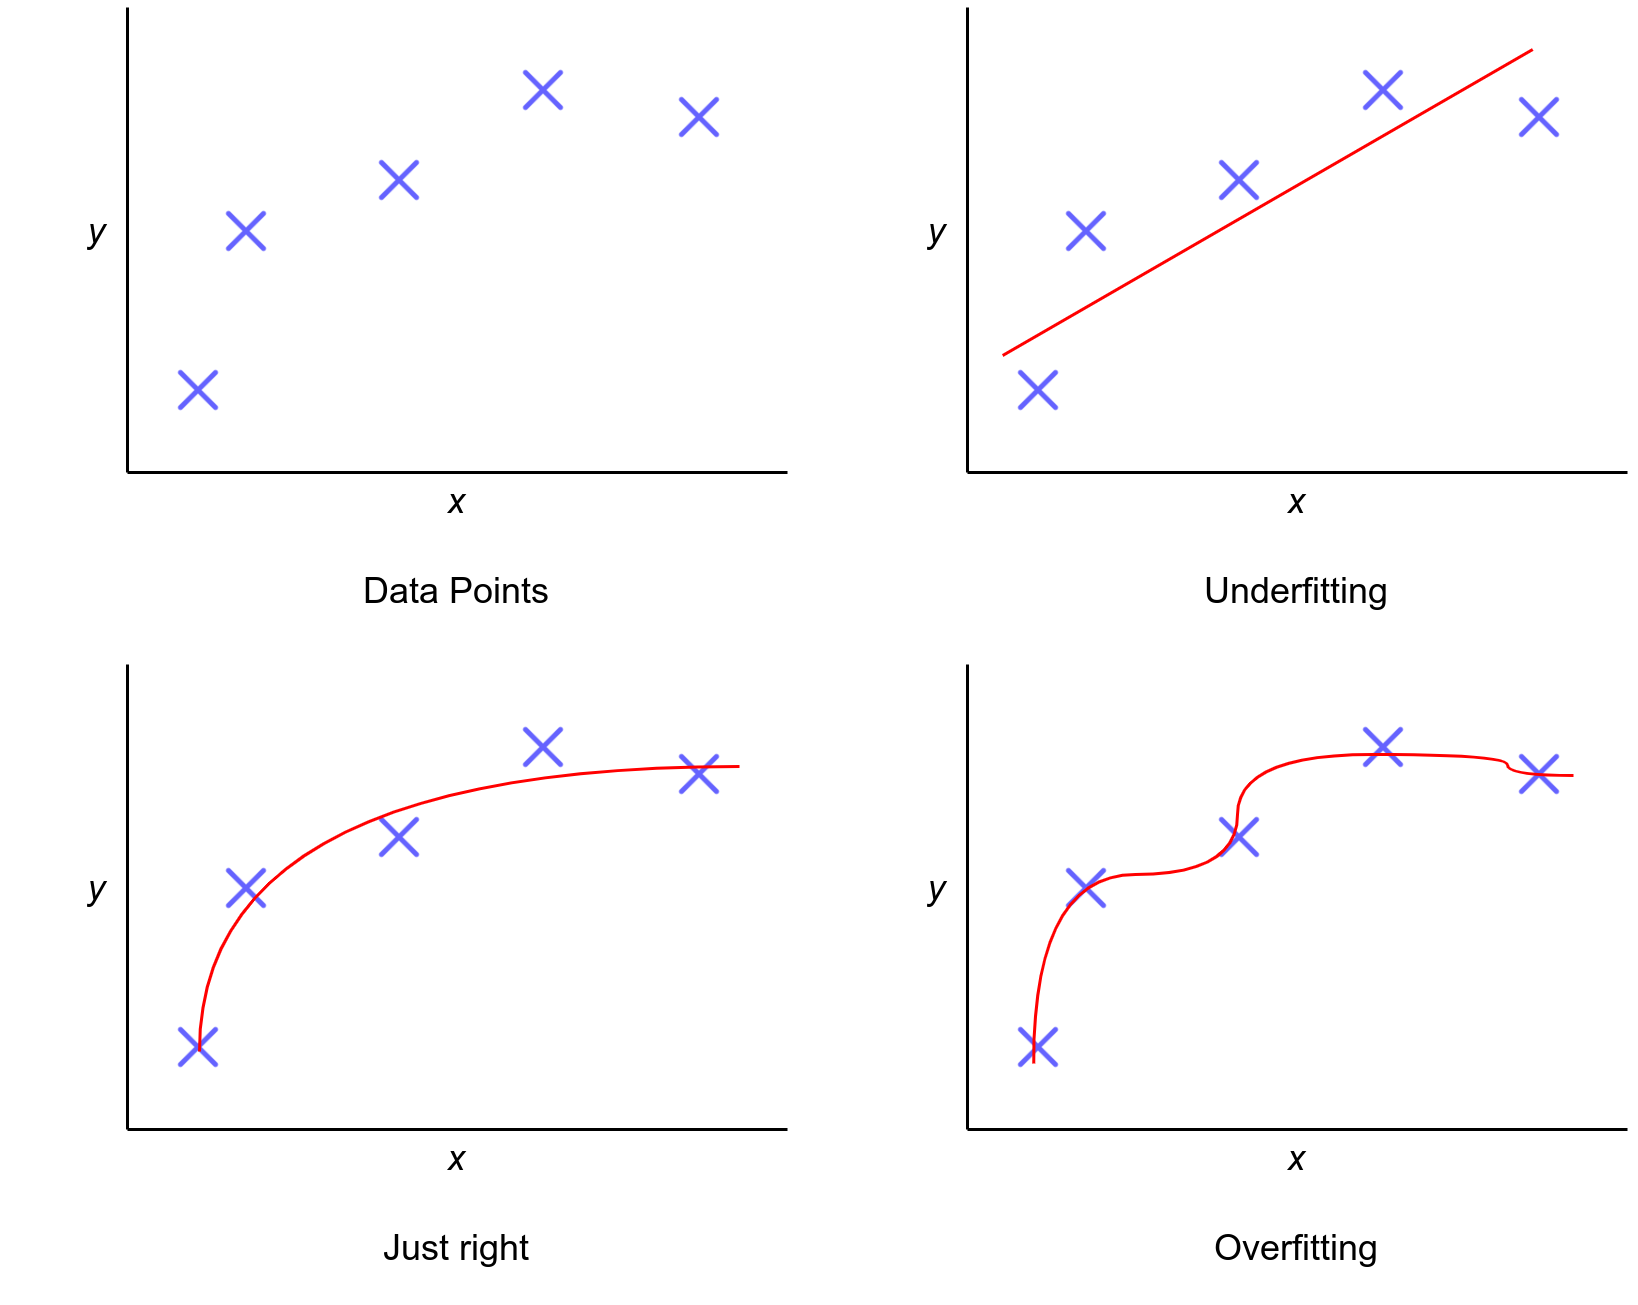

In [12]:
import numpy as np
from datasets import load_metric

def compute_metrics(eval_pred):
    load_accuracy = load_metric("accuracy")
    load_f1 = load_metric("f1")

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
    return {"accuracy": accuracy, "f1": f1}

ImportError: cannot import name 'load_metric' from 'datasets' (/usr/local/lib/python3.12/dist-packages/datasets/__init__.py)

## Training BERT 🚀

 DistilBERT is a smaller, faster and cheaper version of BERT. It has 40% smaller than BERT and runs 60% faster while preserving over 95% of BERT’s performance.

In [ ]:
from transformers import TrainingArguments, Trainer

repo_name = "finetuning-sentiment-model-3000-samples"

training_args = TrainingArguments(
    output_dir=repo_name,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    save_strategy="epoch",
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

Cloning https://huggingface.co/jana-kab/finetuning-sentiment-model-3000-samples into local empty directory.


Download file pytorch_model.bin:   0%|          | 16.5k/255M [00:00<?, ?B/s]

Download file training_args.bin: 100%|##########| 3.43k/3.43k [00:00<?, ?B/s]

Download file runs/Mar06_14-56-57_161794f75320/events.out.tfevents.1678114643.161794f75320.557.0: 100%|#######…

Clean file training_args.bin:  29%|##9       | 1.00k/3.43k [00:00<?, ?B/s]

Clean file runs/Mar06_14-56-57_161794f75320/events.out.tfevents.1678114643.161794f75320.557.0: 100%|##########…

Clean file pytorch_model.bin:   0%|          | 1.00k/255M [00:00<?, ?B/s]

In [ ]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 300
  Batch size = 16
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


<ipython-input-11-6b0938f570ed>:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  load_accuracy = load_metric("accuracy")


{'eval_loss': 0.6938841938972473,
 'eval_accuracy': 0.5,
 'eval_f1': 0.0,
 'eval_runtime': 8.9447,
 'eval_samples_per_second': 33.539,
 'eval_steps_per_second': 2.124}

In [ ]:
trainer.push_to_hub()

Saving model checkpoint to finetuning-sentiment-model-3000-samples
Configuration saved in finetuning-sentiment-model-3000-samples/config.json
Model weights saved in finetuning-sentiment-model-3000-samples/pytorch_model.bin
tokenizer config file saved in finetuning-sentiment-model-3000-samples/tokenizer_config.json
Special tokens file saved in finetuning-sentiment-model-3000-samples/special_tokens_map.json


Upload file pytorch_model.bin:   0%|          | 32.0k/255M [00:00<?, ?B/s]

Upload file runs/Mar06_18-46-07_2c22a6920126/events.out.tfevents.1678128461.2c22a6920126.822.0: 100%|#########…

Upload file training_args.bin: 100%|##########| 3.43k/3.43k [00:00<?, ?B/s]

remote: Scanning LFS files of refs/heads/main for validity...        
remote: LFS file scan complete.        
To https://huggingface.co/jana-kab/finetuning-sentiment-model-3000-samples
   ab8125a..c4f335c  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/jana-kab/finetuning-sentiment-model-3000-samples
   ab8125a..c4f335c  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Text Classification', 'type': 'text-classification'}, 'dataset': {'name': 'imdb', 'type': 'imdb', 'config': 'plain_text', 'split': 'test', 'args': 'plain_text'}}
To https://huggingface.co/jana-kab/finetuning-sentiment-model-3000-samples
   c4f335c..820c771  main -> main

   c4f335c..820c771  main -> main



'https://huggingface.co/jana-kab/finetuning-sentiment-model-3000-samples/commit/c4f335ce77caf303b4a097a81ffaba39fa795de5'

# Testing the pipeline

In [ ]:
from transformers import pipeline

sentiment_model = pipeline(model="federicopascual/finetuning-sentiment-model-3000-samples")

sentiment_model(["I love this move", "This movie sucks!"])

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--federicopascual--finetuning-sentiment-model-3000-samples/snapshots/11f7d327123ebcddd97304c57084c6365628dda5/config.json
Model config DistilBertConfig {
  "_name_or_path": "federicopascual/finetuning-sentiment-model-3000-samples",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--federicopascual--finet

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--federicopascual--finetuning-sentiment-model-3000-samples/snapshots/11f7d327123ebcddd97304c57084c6365628dda5/pytorch_model.bin
All model checkpoint weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassification were initialized from the model checkpoint at federicopascual/finetuning-sentiment-model-3000-samples.
If your task is similar to the task the model of the checkpoint was trained on, you can already use DistilBertForSequenceClassification for predictions without further training.


loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--federicopascual--finetuning-sentiment-model-3000-samples/snapshots/11f7d327123ebcddd97304c57084c6365628dda5/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--federicopascual--finetuning-sentiment-model-3000-samples/snapshots/11f7d327123ebcddd97304c57084c6365628dda5/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--federicopascual--finetuning-sentiment-model-3000-samples/snapshots/11f7d327123ebcddd97304c57084c6365628dda5/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--federicopascual--finetuning-sentiment-model-3000-samples/snapshots/11f7d327123ebcddd97304c57084c6365628dda5/tokenizer_config.json


[{'label': 'LABEL_1', 'score': 0.9558863043785095},
 {'label': 'LABEL_0', 'score': 0.9413502216339111}]

In the IMDB dataset, Label 1 means positive and Label 0 is negative. Quite good! 🔥